In [13]:
from simulation.allen import allen_cahn_next_step
import numpy as np
from matplotlib import pyplot as plt
from utils import GRF1D
from tqdm import tqdm
import torch


# Parameters
nx = 256
xmin = 0.0
xmax = 2.0
x = np.linspace(xmin, xmax, nx)
dx = (xmax - xmin) / (nx - 1)

# # Initial condition (you can replace this with any valid initial condition)
params = torch.randn(1, nx)
u = GRF1D(params)
u = u[0].numpy()

# # Compute the next time step
# traj = [u]
# for _ in range(20000):
#     traj.append(allen_cahn_next_step(traj[-1], x, xi, nu, dt))
# # u_next = allen_cahn_next_step(u, x, xi, nu, dt)

# plt.figure()
# plt.imshow(np.array(traj).T, aspect='auto')
# plt.colorbar()


# Allen-Cahn parameters
xi = 0.015
nu = 1.0
dt = 1e-5

# Initial condition (you can modify this to suit your problem)
# u = np.sin(2 * np.pi * x)  # Example: sine wave initial condition

# Time stepping loop (run for a few steps)
for _ in tqdm(range(10000)):
    traj = [u]
    n_steps = 140
    for step in range(n_steps):
        traj.append(allen_cahn_next_step(traj[-1], dx, xi, nu, dt))


# plt.plot(x, u)
# # At this point, 'u' contains the solution after 'n_steps' time steps

100%|██████████| 10000/10000 [00:54<00:00, 182.70it/s]


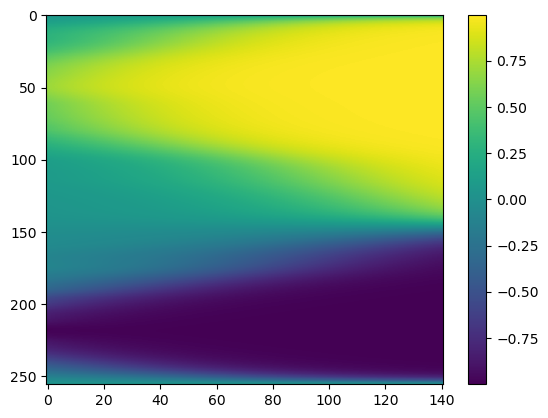

In [14]:
plt.figure()
plt.imshow(np.array(traj).T, aspect='auto')
plt.colorbar()

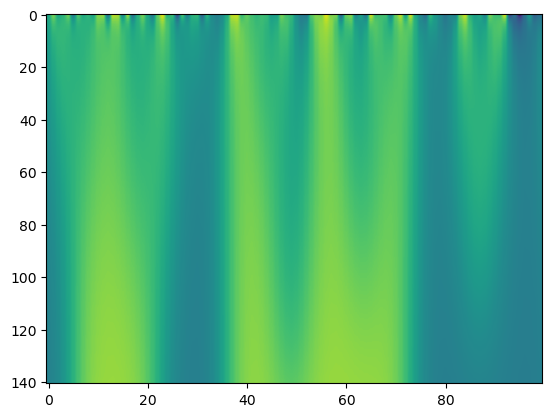

In [12]:
import torch

def laplacian_periodic_torch(u, dx):
    """
    Approximates the Laplacian using periodic boundary conditions with batched input support.
    
    Args:
        u: Tensor of shape (batch_size, nx) representing function values at each grid point.
        dx: The grid spacing (assuming uniform grid).
        
    Returns:
        uxx: The second derivative (Laplacian) of u with periodic boundary conditions.
    """
    uxx = torch.zeros_like(u)
    
    # Compute second derivative using central difference, with periodic boundary conditions
    uxx[:, 1:-1] = (u[:, 2:] - 2 * u[:, 1:-1] + u[:, :-2]) / dx**2
    
    # Periodic boundary conditions
    uxx[:, 0] = (u[:, 1] - 2 * u[:, 0] + u[:, -1]) / dx**2  # Left boundary wraps to the rightmost point
    uxx[:, -1] = (u[:, 0] - 2 * u[:, -1] + u[:, -2]) / dx**2  # Right boundary wraps to the leftmost point
    
    return uxx

def allen_cahn_deriv_torch(u, dx, xi, nu):
    """
    Computes the time derivative of the Allen-Cahn equation with periodic boundary conditions for batched inputs.
    
    Args:
        u: Tensor of shape (batch_size, nx) representing the current state values.
        dx: The grid spacing (assuming uniform grid).
        xi: Interface thickness parameter.
        nu: Diffusion coefficient.
        
    Returns:
        dudt: Tensor of shape (batch_size, nx) representing the time derivative of u.
    """
    # Compute second derivative (Laplacian) with periodic boundary conditions
    uxx = laplacian_periodic_torch(u, dx)
    
    # Allen-Cahn time derivative
    dudt = nu * uxx - (u * (u**2 - 1)) / (2 * xi**2)
    
    return dudt

def allen_cahn_next_step_torch(u, dx, xi=0.015, nu=1.0, dt=1e-5):
    """
    Computes the next time step for the Allen-Cahn equation using Euler's method, with batched inputs.
    
    Args:
        u: Tensor of shape (batch_size, nx) representing the current state values.
        dx: The grid spacing.
        xi: Interface thickness parameter.
        nu: Diffusion coefficient.
        dt: The time step size.
        
    Returns:
        u_next: Tensor of shape (batch_size, nx) representing the state values at the next time step.
    """
    # Compute the time derivative (du/dt)
    dudt = allen_cahn_deriv_torch(u, dx, xi, nu)
    
    # Compute the next state values using Euler's method
    u_next = u + dudt * dt
    
    return u_next

# Example usage:
# Batch size: 10, Grid points: 100, Grid spacing: 0.01
batch_size, nx, dx = 10, 100, 0.01
u_initial = torch.randn(batch_size, nx)  # Random initial conditions

# Parameters for the Allen-Cahn equation
xi = 0.015
nu = 1.0
dt = 1e-5

traj = [u_initial]
for _ in range(140):
    traj.append(allen_cahn_next_step_torch(traj[-1], dx, xi, nu, dt))

traj = torch.stack(traj, dim=1)



plt.figure()
plt.imshow(traj[0].detach().numpy(), aspect='auto')



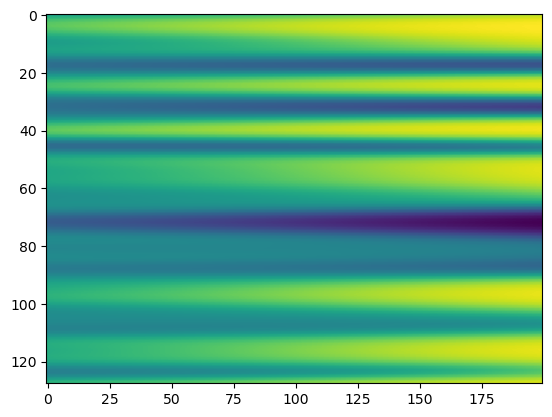

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def step_forward(u, dx, dt, epsilon):
    """
    Perform one time step update for the 1D Allen-Cahn equation with periodic boundary conditions.

    Parameters:
    - u: The current state (array)
    - dx: Spatial step size
    - dt: Time step size
    - epsilon: Diffusion coefficient

    Returns:
    - The updated state after time step dt
    """
    # Apply periodic boundary conditions
    def apply_periodic_bc(u):
        u[0] = u[-2]
        u[-1] = u[1]
        return u

    # Compute the second spatial derivative using central differences
    def rhs_ac(u, dx, epsilon):
        u_xx = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
        f_prime = u**3 - u  # Nonlinear term f'(u) = u^3 - u
        return epsilon * u_xx - f_prime

    # Compute the right-hand side (RHS) of the Allen-Cahn equation
    u_rhs = rhs_ac(u, dx, epsilon)
    
    # Update the state using a forward Euler step
    u_new = u + dt * u_rhs
    
    # Apply periodic boundary conditions
    u_new = apply_periodic_bc(u_new)

    return u_new

# Example usage:
L = 10.0              # Length of the domain
Nx = 128              # Number of spatial grid points
dx = L / Nx           # Spatial resolution
epsilon = 0.01        # Diffusion coefficient
dt = 0.01             # Time step size

# Initial condition
x = np.linspace(0, L, Nx)
u_initial = 0.1 * np.random.randn(Nx)

# Perform a single time step
u_next = step_forward(u_initial, dx, dt, epsilon)

traj = [u_initial]
for _ in range(1000):
    traj.append(step_forward(traj[-1], dx, dt, epsilon))


plt.figure()
plt.imshow(np.array(traj).T[:,200:400], aspect='auto')
# print(u_next)


[ 1.6702122  -0.9976644  -0.28526019  0.96320475 -1.16013561  0.99741634
 -0.80104848  0.16226627  0.0906129  -0.47730912  0.6101479   0.12571325
 -0.4751689   0.40266895  0.49543176 -0.89099302  1.06378902 -0.38797781
 -0.00614758  0.33206586 -0.37558245  0.43680686 -0.4764349   0.81051342
 -1.18142093  1.26592986 -0.88410802  0.3063499   0.23714818 -0.41455228
  0.57758144 -0.1465855  -0.36203279  0.59425251 -0.61290686  0.60266217
 -0.14223698 -0.62547305  1.08479126 -1.3621216   0.85136602  0.09591411
 -0.4280806  -0.09158185  0.27680387 -0.30762472  0.30868496 -0.45381879
  0.05160449  0.41033207 -0.51632995  0.09942497  0.31213581 -0.2362281
  0.38464721  0.11123617 -0.63270148  0.63256327 -0.19164012 -0.18650828
  0.19923909 -0.31211624  0.56458897 -0.64883741 -0.02947322  0.15956999
 -0.16423899 -0.28318289  0.93124819 -0.75858295  0.00620238  0.43197974
  0.4005707  -0.97385614  1.07375237 -0.35735702  0.02539705  0.26386121
 -0.26810095  0.57046191 -0.77223648  0.63608481 -1.

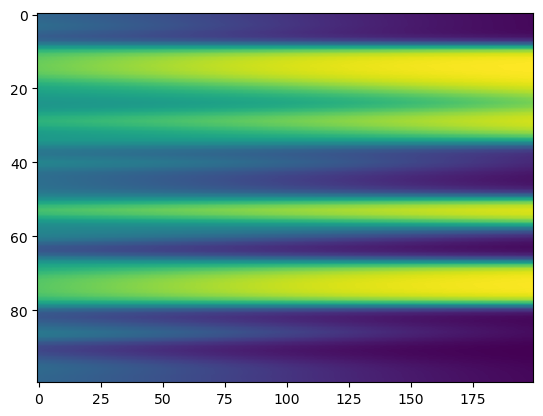

In [8]:
import numpy as np

def step_forward_cahn_hilliard(u, dx, dt, epsilon, M):
    """
    Perform one time step update for the 1D Cahn-Hilliard equation with periodic boundary conditions.
    
    Parameters:
    - u: The current state (array)
    - dx: Spatial step size
    - dt: Time step size
    - epsilon: Diffusion coefficient
    - M: Mobility constant
    
    Returns:
    - The updated state after time step dt
    """
    # Apply periodic boundary conditions
    def apply_periodic_bc(u):
        u[0] = u[-2]
        u[-1] = u[1]
        return u

    # Compute second derivative with central finite differences
    def laplacian(u, dx):
        return (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2

    # Compute the right-hand side of the Cahn-Hilliard equation
    def rhs_ch(u, dx, epsilon):
        # First we compute the chemical potential mu = epsilon * laplacian(u) - f'(u)
        u_xx = laplacian(u, dx)
        f_prime = u**3 - u  # Nonlinear term f'(u) = u^3 - u
        mu = epsilon * u_xx - f_prime
        
        # Now compute the laplacian of mu (fourth-order derivative)
        mu_xx = laplacian(mu, dx)
        
        return M * mu_xx

    # Compute the right-hand side (RHS) of the Cahn-Hilliard equation
    u_rhs = rhs_ch(u, dx, epsilon)
    
    # Update the state using a forward Euler step
    u_new = u + dt * u_rhs
    
    # Apply periodic boundary conditions
    u_new = apply_periodic_bc(u_new)

    return u_new

# Example usage:
L = 10.0              # Length of the domain
Nx = 100              # Number of spatial grid points
dx = L / Nx           # Spatial resolution
epsilon = 0.01        # Diffusion coefficient
M = 1.0               # Mobility constant
dt = 0.01            # Time step size

# Initial condition
x = np.linspace(0, L, Nx)
# u_initial = 0.1 * np.random.randn(Nx)
u = np.sin(2 * np.pi * x) + 0.1 * np.random.randn(Nx)

# Perform a single time step
u_next = step_forward_cahn_hilliard(u_initial, dx, dt, epsilon, M)

print(u_next)


traj = [u_initial]
for _ in range(1000):
    traj.append(step_forward(traj[-1], dx, dt, epsilon))


plt.figure()
plt.imshow(np.array(traj).T[:,200:400], aspect='auto')
# print(u_next)

